# Setup

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from catboost.metrics import BuiltinMetric
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

# Prepare the data

In [50]:
df = pd.read_csv('../dataset/survey.csv')
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [51]:
# Plot nilai nunique dari setiap kolom
fig = px.bar(x=df.columns, y=df.nunique(), title='Jumlah nilai unik dari setiap kolom')
fig.show()

## Preprocess missing values

In [52]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values()

fig = px.bar(missing, x=missing.index, y=missing.values, title='Missing Values')
fig.show()

In [55]:
fig = px.pie(df, names='treatment', title='Distribusi Target')
fig.show()

In [44]:
# Encode kolom self_employed, dan work_interfere
df['self_employed'] = df['self_employed'].replace({'Yes': 1, 'No': 0})
df['work_interfere'] = df['work_interfere'].replace({'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3})

In [45]:
imputer = KNNImputer(n_neighbors=3)
df[['self_employed', 'work_interfere']] = imputer.fit_transform(df[['self_employed', 'work_interfere']])
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,0.000000,No,Yes,3.0,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,0.333333,No,No,1.0,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,0.333333,No,No,1.0,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,0.000000,Yes,Yes,3.0,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,0.333333,No,No,0.0,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [46]:
df['work_interfere'] = df['work_interfere'].round().astype(int)
df['self_employed'] = df['self_employed'].round().astype(int)
df['work_interfere'] = df['work_interfere'].replace({0: 'Never', 1: 'Rarely', 2: 'Sometimes', 3: 'Often'})
df['self_employed'] = df['self_employed'].replace({0: 'No', 1: 'Yes'})

## Preprocess gender columns

In [47]:
df.drop(columns=['state', 'comments', 'Gender', 'Timestamp', 'Country', 'Age', 'self_employed', 'no_employees', 'remote_work', 'tech_company'], inplace=True)
df.head()

,family_history,treatment,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,No,Yes,Often,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,No,No,Rarely,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,No,No,Rarely,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,Yes,Yes,Often,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,No,No,Never,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


## Summary the columns

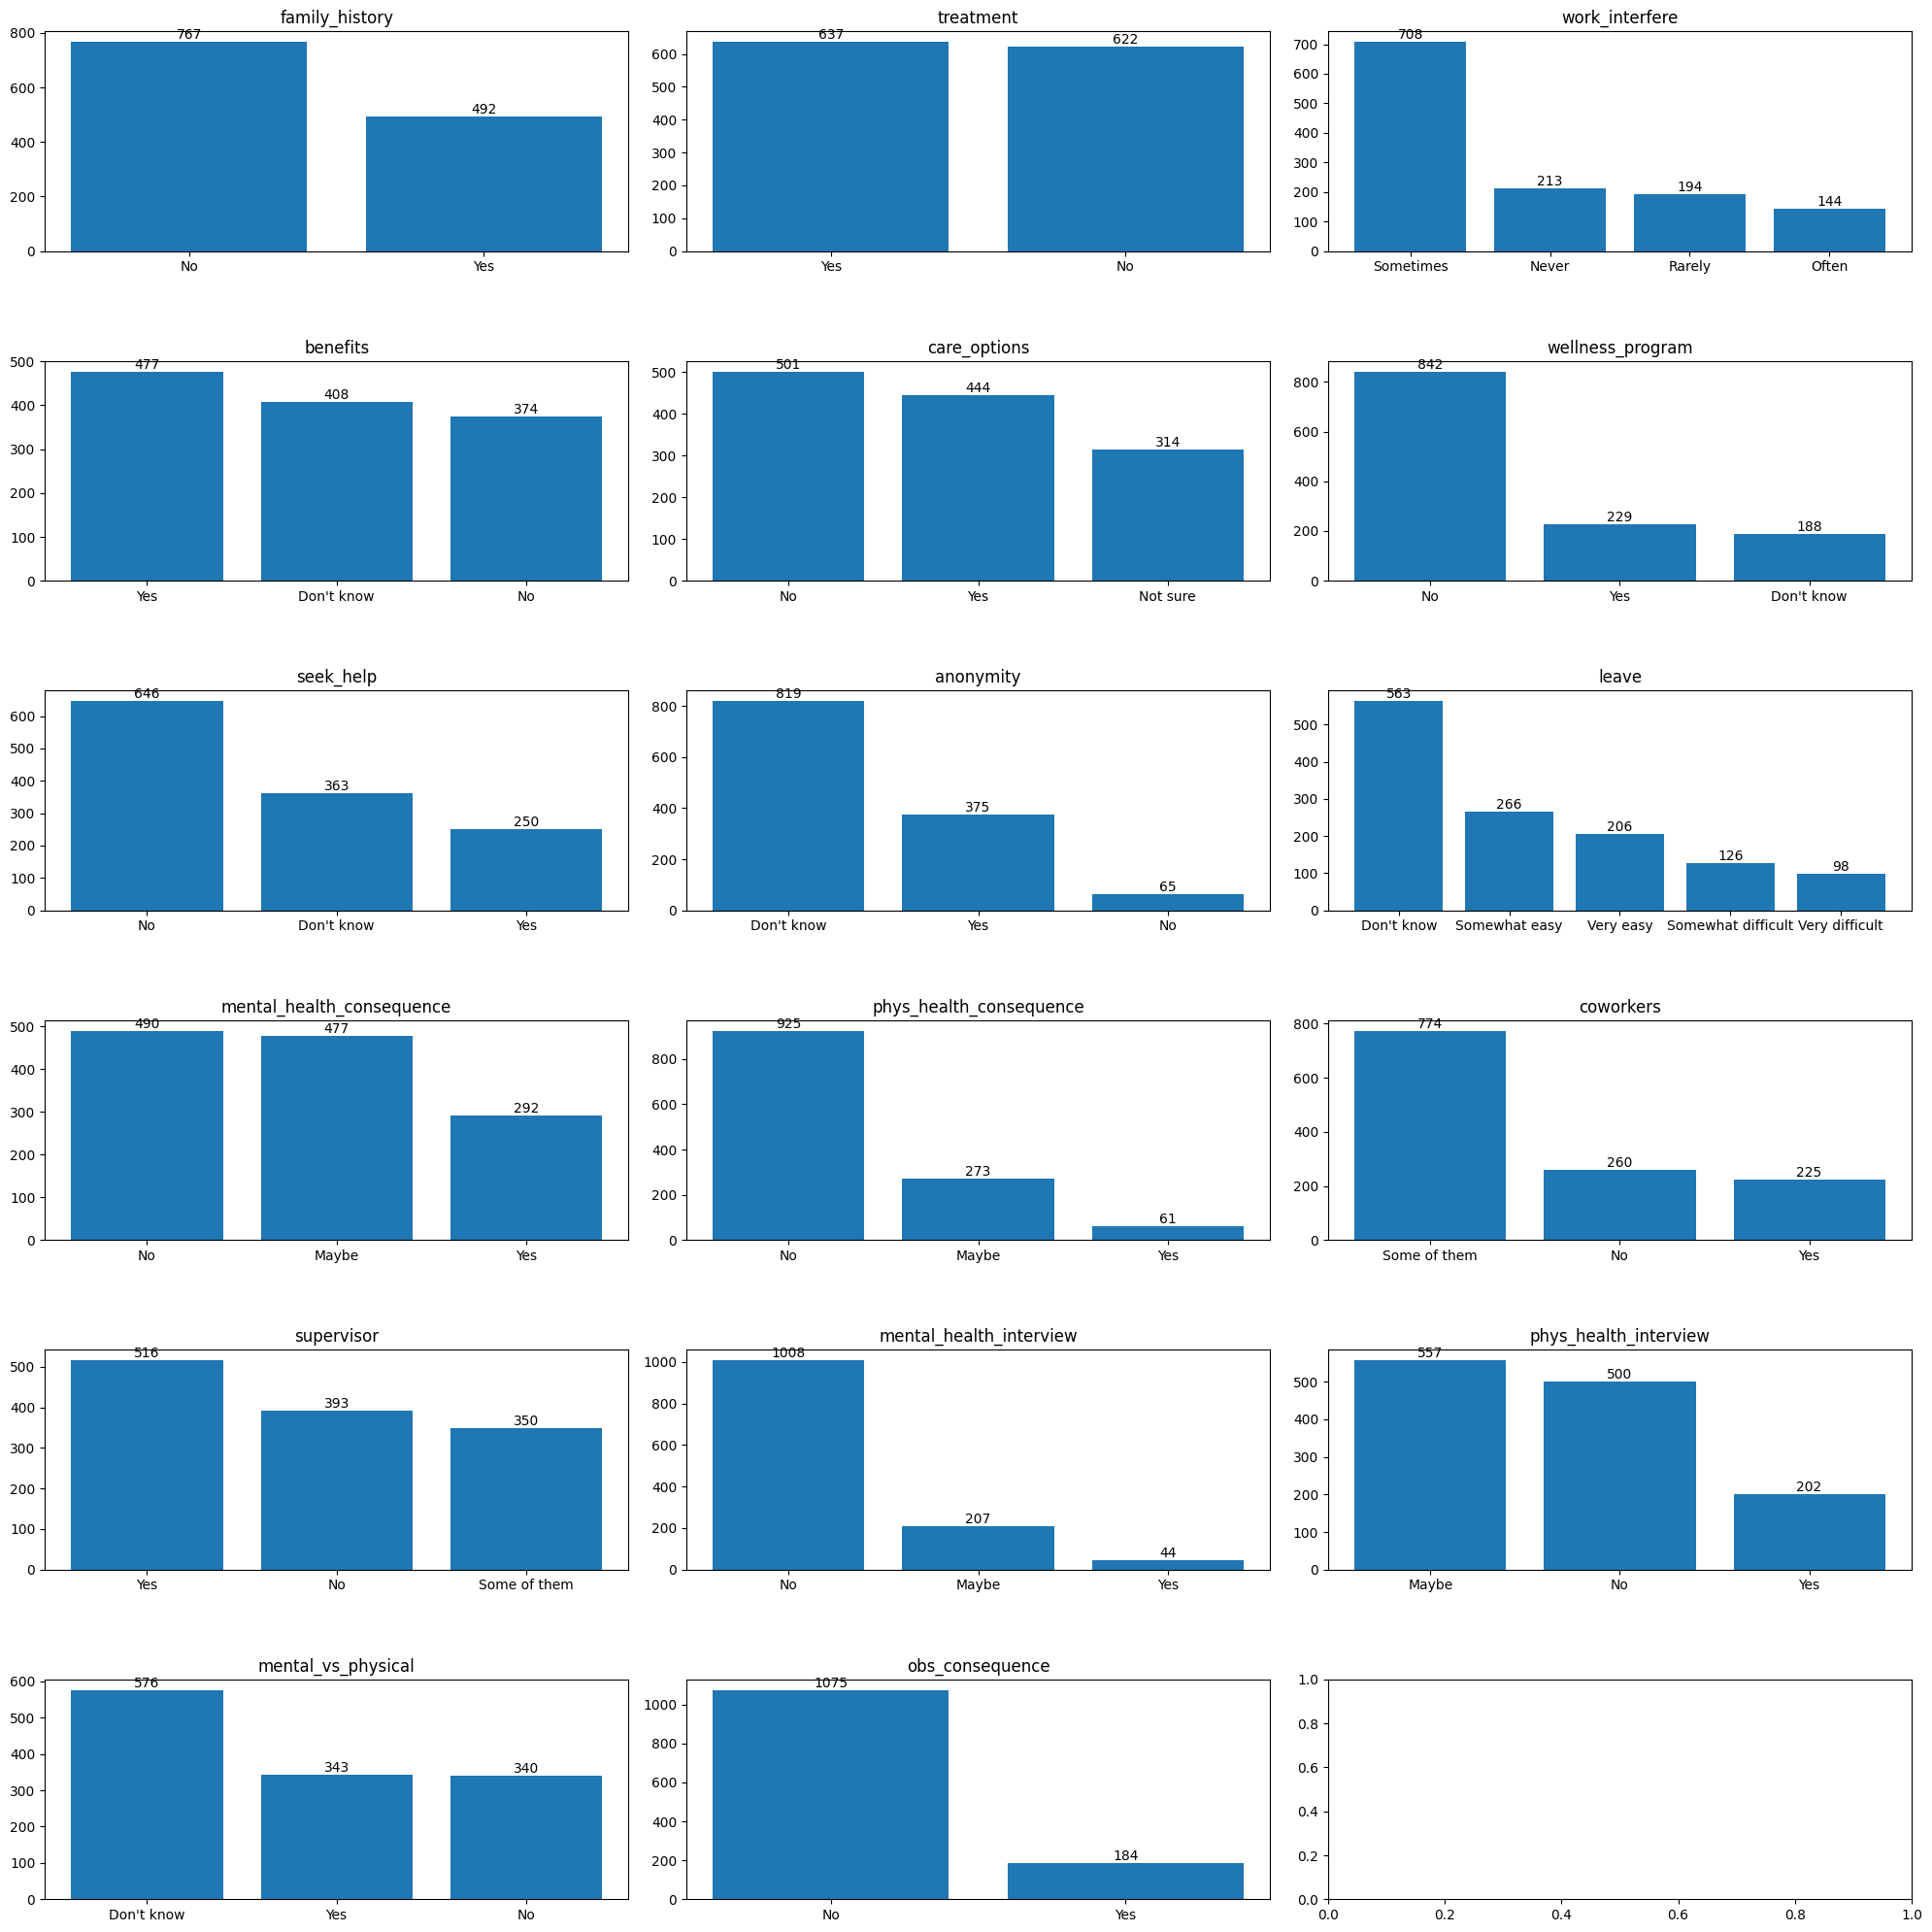

In [12]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))

for i, column in enumerate(df.columns):
    index = df[column].value_counts().index
    values = df[column].value_counts().values
    ax = axes[i//3, i%3]
    ax.bar(index, values)
    for i, v in enumerate(values):
        ax.text(i, v, str(v), ha='center', va='bottom')
    ax.set_title(column)
    ax.set_xticklabels(index)
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

In [11]:
df.to_csv('../dataset/cleaned_survey.csv', index=False)

In [56]:
df = pd.read_csv('../dataset/cleaned_survey.csv')
df.head()

,family_history,treatment,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,No,Yes,Often,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,No,No,Rarely,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,No,No,Rarely,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,Yes,Yes,Often,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,No,No,Never,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


## Ordinal encoder

In [57]:
def ordinal_encoder(df):
    encodings = {
        'encode1': ['No', 'Yes'],
        'encode2': ['Never', 'Rarely', 'Sometimes', 'Often'],
        'encode3': ['No', 'Not sure', 'Yes'],
        'encode4': ['Very difficult', 'Somewhat difficult', "Don't know", 'Somewhat easy', 'Very easy'],
        'encode5': ['No', 'Maybe', 'Yes'],
        'encode6': ['No', 'Some of them', 'Yes'],
        'encode7': ['No', "Don't know", 'Yes']
    }
    
    encoding_lookup = {frozenset(v): k for k, v in encodings.items()}

    for column in df.columns:
        if df[column].dtype == 'object':
            unique_values = frozenset(df[column].unique())
            if unique_values in encoding_lookup:
                encoder_key = encoding_lookup[unique_values]
                encoder = OrdinalEncoder(categories=[encodings[encoder_key]])
                df[column] = encoder.fit_transform(df[[column]]).astype(int)
    
    return df

df = ordinal_encoder(df)
df

,family_history,treatment,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,0,1,3,2,1,0,2,2,3,0,0,1,2,0,1,2,0
1,0,0,1,1,0,1,1,1,2,1,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,1,1,0,0,2,2,2,2,0,0
3,1,1,3,0,2,0,0,0,1,2,2,1,0,1,1,0,1
4,0,0,0,2,0,1,1,1,2,0,0,1,2,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0,1,2,0,0,0,0,1,3,0,0,1,1,0,0,1,0
1255,1,1,3,2,2,0,0,2,1,0,0,1,2,0,0,2,0
1256,1,1,2,2,2,0,0,1,1,2,2,0,0,0,0,0,0
1257,0,0,2,0,2,0,0,1,2,2,0,0,0,0,0,0,0


In [58]:
# save the dataset
df.to_csv('../dataset/cleaned_survey.csv', index=False)

## Feature selection

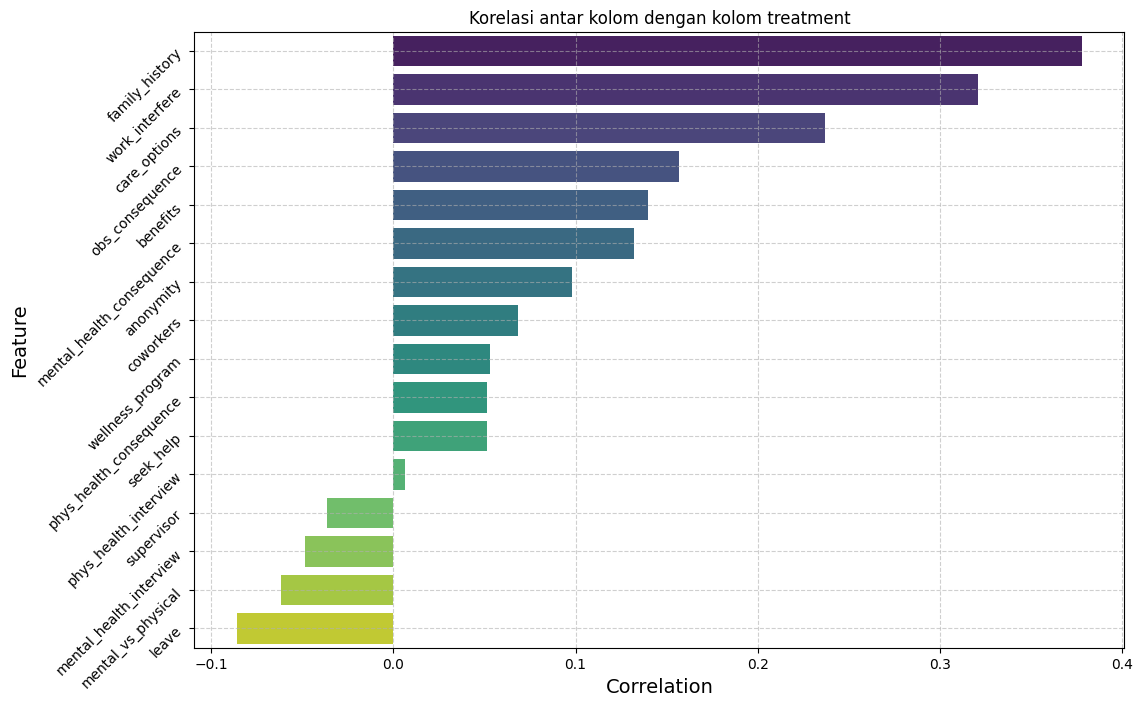

In [59]:
corr_df = df.copy()
correlation_series = corr_df.drop(columns=['treatment']).corrwith(corr_df['treatment'])

df_dummies = pd.DataFrame({
    'Feature': correlation_series.index,
    'Correlation': correlation_series.values
}).sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_dummies, x='Correlation', y='Feature', palette='viridis')
plt.yticks(rotation=45)
plt.title('Korelasi antar kolom dengan kolom treatment', fontsize=12)
plt.xlabel('Correlation', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Generate the model

## Oversampling

In [103]:
df = pd.read_csv('../dataset/cleaned_survey.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   family_history             1259 non-null   int64
 1   treatment                  1259 non-null   int64
 2   work_interfere             1259 non-null   int64
 3   benefits                   1259 non-null   int64
 4   care_options               1259 non-null   int64
 5   wellness_program           1259 non-null   int64
 6   seek_help                  1259 non-null   int64
 7   anonymity                  1259 non-null   int64
 8   leave                      1259 non-null   int64
 9   mental_health_consequence  1259 non-null   int64
 10  phys_health_consequence    1259 non-null   int64
 11  coworkers                  1259 non-null   int64
 12  supervisor                 1259 non-null   int64
 13  mental_health_interview    1259 non-null   int64
 14  phys_health_interview   

In [104]:
df_majority = df[df.treatment == 0]
df_minority = df[df.treatment == 1]

total_current = len(df_minority) + len(df_majority)
required_samples = 10000 - len(df)

minority_samples_needed = (required_samples // 2) + (required_samples % 2)
majority_samples_needed = required_samples // 2

df_minority_oversampled = resample(
    df_minority, 
    replace=True,     
    n_samples=minority_samples_needed,
    random_state=42
)

df_majority_oversampled = resample(
    df_majority, 
    replace=True,     
    n_samples=majority_samples_needed,
    random_state=42
)

df_oversampled = pd.concat([
    df_majority, 
    df_majority_oversampled, 
    df_minority, 
    df_minority_oversampled
])

df = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['treatment'].value_counts())
print(df.shape)

treatment
1    5008
0    4992
Name: count, dtype: int64
(10000, 17)


## Tuning seed

In [105]:
X = df.drop(columns=['treatment'])
y = df['treatment']

In [106]:
accuracy = []

for i in range(400):
    print(f"Training model ke-{i+1}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    cat = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=10,
        loss_function='Logloss',
        verbose=5,
        eval_metric='Accuracy',
        use_best_model=True,
        random_seed=i
    )

    cat.fit(
        X_train, 
        y_train, 
        eval_set=(X_test, y_test), 
        verbose=100
    )
    
    y_pred = cat.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    
    print("")

Training model ke-1
0:	learn: 0.7991250	test: 0.7865000	best: 0.7865000 (0)	total: 10.5ms	remaining: 1.04s
99:	learn: 0.9783750	test: 0.9735000	best: 0.9735000 (99)	total: 379ms	remaining: 0us

bestTest = 0.9735
bestIteration = 99


Training model ke-2
0:	learn: 0.7385000	test: 0.7270000	best: 0.7270000 (0)	total: 2.13ms	remaining: 211ms
99:	learn: 0.9803750	test: 0.9675000	best: 0.9675000 (99)	total: 422ms	remaining: 0us

bestTest = 0.9675
bestIteration = 99


Training model ke-3
0:	learn: 0.8165000	test: 0.8125000	best: 0.8125000 (0)	total: 3.33ms	remaining: 330ms
99:	learn: 0.9805000	test: 0.9730000	best: 0.9730000 (99)	total: 455ms	remaining: 0us

bestTest = 0.973
bestIteration = 99


Training model ke-4
0:	learn: 0.8087500	test: 0.7985000	best: 0.7985000 (0)	total: 8.18ms	remaining: 810ms
99:	learn: 0.9778750	test: 0.9575000	best: 0.9580000 (94)	total: 718ms	remaining: 0us

bestTest = 0.958
bestIteration = 94

Shrink model to first 95 iterations.

Training model ke-5
0:	learn: 0.7

In [107]:
best_model_index = accuracy.index(max(accuracy))
best_model_index

51

## Train the model

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=10, 
    loss_function='Logloss',
    verbose=5,
    eval_metric='Accuracy',
    use_best_model=True,
    random_seed=104
)

cat.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test), 
    verbose=100
)

0:	learn: 0.8050000	test: 0.7885000	best: 0.7885000 (0)	total: 9.08ms	remaining: 9.07s
100:	learn: 0.9942500	test: 0.9895000	best: 0.9900000 (73)	total: 657ms	remaining: 5.84s
200:	learn: 0.9950000	test: 0.9915000	best: 0.9915000 (125)	total: 1.23s	remaining: 4.91s
300:	learn: 0.9951250	test: 0.9910000	best: 0.9915000 (125)	total: 1.81s	remaining: 4.21s
400:	learn: 0.9951250	test: 0.9915000	best: 0.9915000 (125)	total: 2.37s	remaining: 3.53s
500:	learn: 0.9951250	test: 0.9915000	best: 0.9915000 (125)	total: 2.95s	remaining: 2.94s
600:	learn: 0.9951250	test: 0.9915000	best: 0.9915000 (125)	total: 3.42s	remaining: 2.27s
700:	learn: 0.9951250	test: 0.9915000	best: 0.9915000 (125)	total: 3.9s	remaining: 1.66s
800:	learn: 0.9951250	test: 0.9915000	best: 0.9915000 (125)	total: 4.4s	remaining: 1.09s
900:	learn: 0.9951250	test: 0.9915000	best: 0.9915000 (125)	total: 4.9s	remaining: 538ms
999:	learn: 0.9951250	test: 0.9915000	best: 0.9915000 (125)	total: 5.37s	remaining: 0us

bestTest = 0.9915


## Metrics evaluation

In [109]:
y_pred = cat.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Accuracy : 0.9915


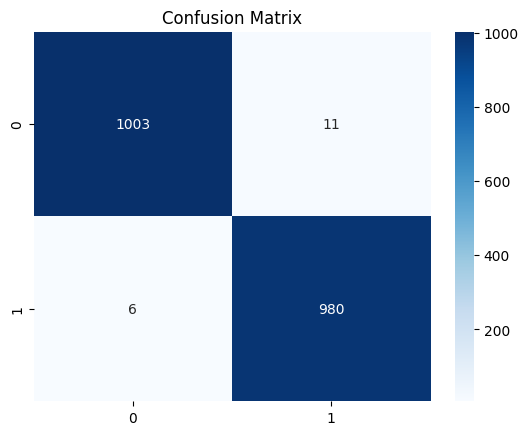

In [110]:
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=cat.classes_, columns=cat.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [111]:
y_pred = cat.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1014
           1       0.99      0.99      0.99       986

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [112]:
cat.save_model('../saved model/catboost_model')

# Testing

In [118]:
cat = CatBoostClassifier()
cat.load_model('../saved model/catboost_model')

In [124]:
data = {
    'family_history': ['No'],
    'work_interfere': ['Never'],
    'benefits': ['No'],
    'care_options': ['No'],
    'wellness_program': ['No'],
    'seek_help': ['No'],
    'anonymity': ['No'],
    'leave': ['Very easy'],
    'mental_health_consequence': ['No'],
    'phys_health_consequence': ['No'],
    'coworkers': ['Some of them'],
    'supervisor': ['No'],
    'mental_health_interview': ['No'],
    'phys_health_interview': ['No'],
    'mental_vs_physical': ['No'],
    'obs_consequence': ['No']
}

data = pd.DataFrame(data)
data.head()

,family_history,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,No,Never,No,No,No,No,No,Very easy,No,No,Some of them,No,No,No,No,No


In [125]:
encode1 = {
    'No': 0,
    'Yes': 1
}

encode2 = {
    'Never': 0,
    'Rarely': 1,
    'Sometimes': 2,
    'Often': 3
}

encode3 = {
    'No': 0,
    'Not sure': 1,
    'Yes': 2
}

encode4 = {
    'Very difficult': 0,
    'Somewhat difficult': 1,
    "Don't know": 2,
    'Somewhat easy': 3,
    'Very easy': 4
}

encode5 = {
    'No': 0,
    'Maybe': 1,
    'Yes': 2
}

encode6 = {
    'No': 0,
    'Some of them': 1,
    'Yes': 2
}

encode7 = {
    'No': 0,
    "Don't know": 1,
    'Yes': 2
}

encodings = {
    'family_history': encode1,
    'work_interfere': encode2,
    'benefits': encode7,
    'care_options': encode3,
    'wellness_program': encode7,
    'seek_help': encode7,
    'anonymity': encode7,
    'leave': encode4,
    'mental_health_consequence': encode5,
    'phys_health_consequence': encode5,
    'coworkers': encode6,
    'supervisor': encode6,
    'mental_health_interview': encode5,
    'phys_health_interview': encode5,
    'mental_vs_physical': encode7,
    'obs_consequence': encode1
}

for column, encoding in encodings.items():
    data[column] = data[column].map(encoding)

data.head()

,family_history,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,0,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0


In [126]:
proba = cat.predict_proba(data)

if proba[0][1] > 0.5:
    print('Pasien memerlukan treatment, dengan probabilitas mental health', proba[0][1])
else:
    print('Pasien tidak memerlukan treatment, dengan probabilitas mental health', proba[0][0])

Pasien tidak memerlukan treatment, dengan probabilitas mental health 0.9923029998522828
